## Step 1. 스티커 구하기 or 만들기

(1) 고양이 수염이미지 [cat-whiskers.png] (flaticon 사이트 공개 이미지 사용.)

(2) 본인 셀카 이미지 촬영

In [1]:
# 사진을 준비하자

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
print("뿅~")

뿅~


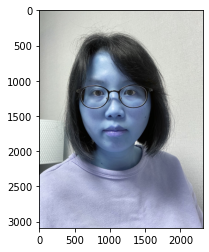

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/bom.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

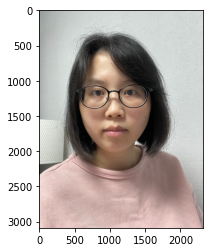

In [3]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## Step 2. 얼굴 검출 & 랜드마크 검출 하기

In [4]:
# 얼굴 검출
# detector를 선언합니다

detector_hog = dlib.get_frontal_face_detector()
print("뿅~")

뿅~


#### 얼굴의 bounding box 위치 찾기

In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("뿅~")

뿅~


rectangles[[(485, 869) (1635, 2019)]]


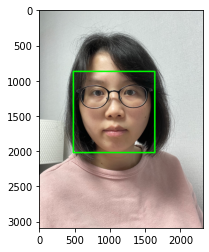

In [6]:
# 찾은 얼굴을 화면에 출력

# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다

print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 20, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#### 얼굴의 landmark의 위치 찾기

In [7]:
# landmark 모델을 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("뿅~")

뿅~


In [8]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    

print(len(list_landmarks[0]))

68


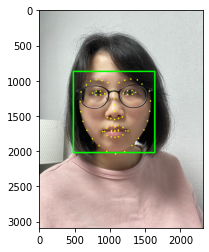

In [9]:
# 랜드마크를 영상에 출력해 보자

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 10, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## Step 3. 스티커 적용 위치 확인하기

In [10]:
# (x,y) 코의 중심점
# (w,h) 스티커의 크기

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    
# 랜드마크 30을 기준

(1067, 1432)
(x,y) : (1067,1432)
(w,h) : (1151,1151)


## Step 4. 스티커 적용하기

(1100, 1100, 3)


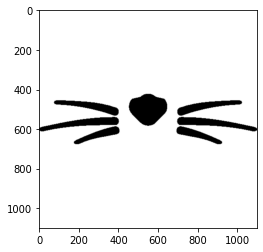

In [11]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (1100,1100) )
print (img_sticker.shape)
plt.imshow(img_sticker)

In [12]:
# 이미지의 좌표 조정
# 스티커 이미지 정중앙보다 약간 왼쪽 위에 고양이 코가 있으므로
# 사진상의 코와 스티커의 정중앙을 맞춰주자

refined_x = int(x - w //2.1) # left
refined_y = int(y - h //2.2)  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y)) 

(x,y) : (519,909)


#### (1) 오늘 배운 np.where 를 사용해서 스티커를 적용

In [13]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
print("뿅~")

뿅~


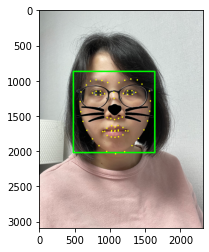

In [14]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#### (2) 스티커를 조금 더 자연스럽게 보이게
스티커 뒤로 원본 이미지가 같이 보이도록 만들어 보자
opencv 의 cv2.addWeighted() 를 참고

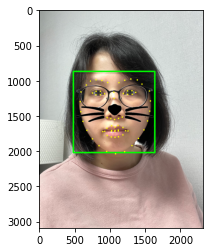

In [15]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.7, 0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

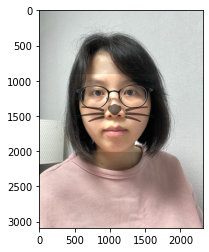

In [16]:
# 완성! 
# bounding box와 landmark를 제거하고 최종 결과만 출력 (show → bgr)

sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.7, 0)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## Step 5. 문제점 찾아보기
#### (1) 셀프 카메라를 다양한 각도에서 촬영하면서 스티커를 반복해서 적용해 보자.
#### (2) 문제점이 무엇인지 최대한 자세하게 기록해 보자.


1. 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?

2. 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?

3. 실행 속도가 중요할까요?

4. 스티커앱을 만들 때 정확도가 얼마나 중요할까요?

### 5-1. 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
#### (1) 비스듬한 각도

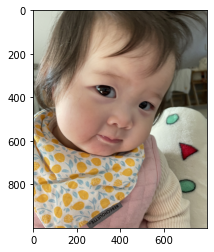

In [17]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_04.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_bgr = cv2.resize(img_bgr, (800, 1000))  # 800x1000의 크기로 Resize
img_show = img_bgr.copy()    # 출력용 이미지를 따로 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    # BGR → RGB 이미지로 바꾸기
plt.imshow(img_rgb)
plt.show()

rectangles[[(204, 247) (589, 632)]]
68


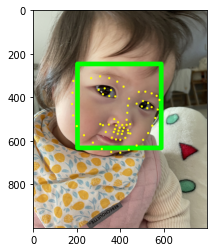

In [18]:
detector_hog = dlib.get_frontal_face_detector()    # detector를 선언합니다
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    # 얼굴의 bounding box 위치 찾기
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print(dlib_rects)   # 찾은 얼굴을 화면에 출력

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 20, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)


# 얼굴의 landmark의 위치 찾기

model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'    # landmark 모델을 불러오기
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)    # 얼굴 영역 박스 마다 face landmark를 찾아냅니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))    # face landmark 좌표를 저장해둡니다
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))

# 랜드마크를 영상에 출력해 보자

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 5, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

(430, 503)
(x,y) : (430,334)
(w,h) : (386,386)
(386, 386, 3)
(x,y) : (237,334)


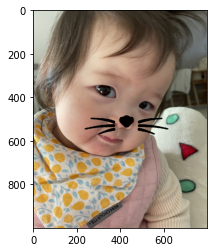

In [19]:
# 스티커 적용 위치 확인하기

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[33][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
plt.imshow(img_sticker)
print (img_sticker.shape)

refined_x = x - w // 2  # left
refined_y = y  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))


sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

#### 5-1.(1) 비스듬한 각도_문제점

* 고개가 비스듬한 각도에서 찍힌 사진에도 정상적으로 고양이 수염 스티커가 붙음.
* 그러나 각도가 맞지 않음.

#### 5-1.(1) 비스듬한 각도_해결방안
* 랜드마크의 회전 각을 구해 스티커에 적용하여 회전된 스티커를 붙임.

rectangles[[(204, 247) (589, 632)]]


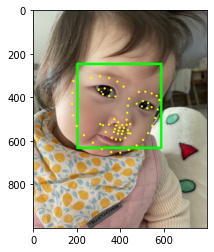

In [20]:
import math # 회전 각 구하는 함수

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_04.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_bgr = cv2.resize(img_bgr, (800, 1000))  # 800x1000의 크기로 Resize
img_show = img_bgr.copy()    # 출력용 이미지를 따로 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    # BGR → RGB 이미지로 바꾸기
# plt.imshow(img_rgb)
# plt.show()

detector_hog = dlib.get_frontal_face_detector()    # detector를 선언합니다
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    # 얼굴의 bounding box 위치 찾기
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print(dlib_rects)   # 찾은 얼굴을 화면에 출력

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 10, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)


# 얼굴의 landmark의 위치 찾기

model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'    # landmark 모델을 불러오기
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)    # 얼굴 영역 박스 마다 face landmark를 찾아냅니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))    # face landmark 좌표를 저장해둡니다
    list_landmarks.append(list_points)
    
# print(len(list_landmarks[0]))

# 랜드마크를 영상에 출력해 보자

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 5, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [21]:
x = []
y = []
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x.append(landmark[30][0])    # x = landmark[30][0]
    y.append(landmark[33][1] - dlib_rect.width()//2)
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(w,h) : (%d,%d)'%(w,h))

# 회전 각 구하기

tan_theta = (landmark[30][0]-landmark[27][0])/(landmark[30][1]-landmark[27][1])
theta = np.arctan(tan_theta)
rotate_angle = theta *180/math.pi
print(rotate_angle)

(w,h) : (386,386)
-6.4698199851731735


(386, 386, 3)


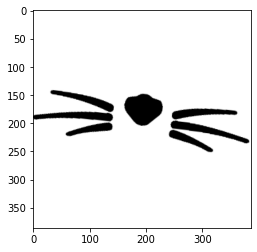

In [22]:
# 고양이 수염 스티커 회전하기

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR,borderValue=(255,255,255))
  return result

img_rotate = rotate_image(img_sticker,rotate_angle)
print(img_rotate.shape)
plt.imshow(img_rotate)
plt.show()

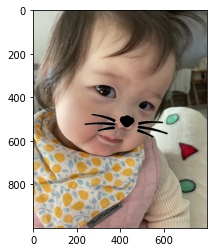

In [23]:
refined_x = []
refined_y = []

for i in range(len(x)):
    refined_x.append(x[i] - w//2)  # left
    refined_y.append(y[i])    # top
    
for i in range(len(x)):
    sticker_area = img_bgr[refined_y[i]:refined_y[i]+img_sticker.shape[0], refined_x[i]:refined_x[i]+img_sticker.shape[1]]
    img_bgr[refined_y[i]:refined_y[i]+img_sticker.shape[0], refined_x[i]:refined_x[i]+img_sticker.shape[1]] = np.where(img_rotate==255,sticker_area,img_rotate).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### (2) 회전된 사진 (90도, 180도, 270도)

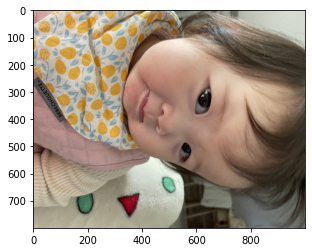

In [24]:
# 90도

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_04_1.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_bgr = cv2.resize(img_bgr, (1000, 800))  # 800x1000의 크기로 Resize
img_show = img_bgr.copy()    # 출력용 이미지를 따로 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    # BGR → RGB 이미지로 바꾸기

# img_rgb90 =cv2.rotate(img_rgb, cv2.ROTATE_90_CLOCKWISE)
# cv2.imshow('original', img_rgb90)

plt.imshow(img_rgb)
plt.show()

In [25]:
# detector_hog = dlib.get_frontal_face_detector()    # detector를 선언합니다
# img_rgb = cv2.cvtColor(img_rgb90, cv2.COLOR_BGR2RGB)    # 얼굴의 bounding box 위치 찾기
# dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
# print(dlib_rects)   # 찾은 얼굴을 화면에 출력

# for dlib_rect in dlib_rects:
#     l = dlib_rect.left()
#     t = dlib_rect.top()
#     r = dlib_rect.right()
#     b = dlib_rect.bottom()

#     cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 10, lineType=cv2.LINE_AA)

# img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)


# # 얼굴의 landmark의 위치 찾기

# model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'    # landmark 모델을 불러오기
# landmark_predictor = dlib.shape_predictor(model_path)

# list_landmarks = []
# for dlib_rect in dlib_rects:
#     points = landmark_predictor(img_rgb, dlib_rect)    # 얼굴 영역 박스 마다 face landmark를 찾아냅니다
#     list_points = list(map(lambda p: (p.x, p.y), points.parts()))    # face landmark 좌표를 저장해둡니다
#     list_landmarks.append(list_points)
    
# print(len(list_landmarks[0]))

# # 랜드마크를 영상에 출력해 보자

# for landmark in list_landmarks:
#     for point in landmark:
#         cv2.circle(img_rgb90, point, 10, (0, 255, 255), -1)

# img_show_rgb = cv2.cvtColor(img_rgb90, cv2.COLOR_BGR2RGB)
# plt.imshow(img_show_rgb)
# plt.show()

In [26]:
detector_hog = dlib.get_frontal_face_detector()    # detector를 선언합니다
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)    # 얼굴의 bounding box 위치 찾기
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print(dlib_rects)   # 찾은 얼굴을 화면에 출력

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 10, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)


# 얼굴의 landmark의 위치 찾기

model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'    # landmark 모델을 불러오기
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)    # 얼굴 영역 박스 마다 face landmark를 찾아냅니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))    # face landmark 좌표를 저장해둡니다
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))

# 랜드마크를 영상에 출력해 보자

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_rgb, point, 10, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

rectangles[]


IndexError: list index out of range

In [ ]:
# 180도

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_04_2.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_bgr = cv2.resize(img_bgr, (800, 1000))  # 800x1000의 크기로 Resize
img_show = img_bgr.copy()    # 출력용 이미지를 따로 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    # BGR → RGB 이미지로 바꾸기

# img_rgb90 =cv2.rotate(img_rgb, cv2.ROTATE_90_CLOCKWISE)
# cv2.imshow('original', img_rgb90)

plt.imshow(img_rgb)
plt.show()

In [27]:
detector_hog = dlib.get_frontal_face_detector()    # detector를 선언합니다
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)    # 얼굴의 bounding box 위치 찾기
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print(dlib_rects)   # 찾은 얼굴을 화면에 출력

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 10, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)


# 얼굴의 landmark의 위치 찾기

model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'    # landmark 모델을 불러오기
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)    # 얼굴 영역 박스 마다 face landmark를 찾아냅니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))    # face landmark 좌표를 저장해둡니다
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))

# 랜드마크를 영상에 출력해 보자

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_rgb, point, 10, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

rectangles[]


IndexError: list index out of range

In [ ]:
# 270도

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_04_3.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_bgr = cv2.resize(img_bgr, (1000, 800))  # 800x1000의 크기로 Resize
img_show = img_bgr.copy()    # 출력용 이미지를 따로 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    # BGR → RGB 이미지로 바꾸기

# img_rgb90 =cv2.rotate(img_rgb, cv2.ROTATE_90_CLOCKWISE)
# cv2.imshow('original', img_rgb90)

plt.imshow(img_rgb)
plt.show()

In [28]:
detector_hog = dlib.get_frontal_face_detector()    # detector를 선언합니다
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)    # 얼굴의 bounding box 위치 찾기
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print(dlib_rects)   # 찾은 얼굴을 화면에 출력

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 10, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)


# 얼굴의 landmark의 위치 찾기

model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'    # landmark 모델을 불러오기
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)    # 얼굴 영역 박스 마다 face landmark를 찾아냅니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))    # face landmark 좌표를 저장해둡니다
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))

# 랜드마크를 영상에 출력해 보자

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_rgb, point, 10, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

rectangles[]


IndexError: list index out of range

* 회전된 사진에 대해서는 얼굴 영역 박스와 랜드마크 적용이 되지 않았다.
* 랜드마크 인식이 안되면 이미지에 스티커를 적용할 수 없다.

### 5-2. 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
#### (1) 멀리서 촬영한 사진

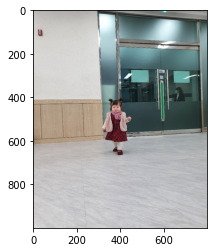

In [29]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_01.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_bgr = cv2.resize(img_bgr, (800, 1000))  # 800x1000의 크기로 Resize
img_show = img_bgr.copy()    # 출력용 이미지를 따로 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    # BGR → RGB 이미지로 바꾸기

# img_rgb90 =cv2.rotate(img_rgb, cv2.ROTATE_90_CLOCKWISE)
# cv2.imshow('original', img_rgb90)

plt.imshow(img_rgb)
plt.show()

In [30]:
detector_hog = dlib.get_frontal_face_detector()    # detector를 선언합니다
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)    # 얼굴의 bounding box 위치 찾기
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print(dlib_rects)   # 찾은 얼굴을 화면에 출력

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 10, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)


# 얼굴의 landmark의 위치 찾기

model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'    # landmark 모델을 불러오기
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)    # 얼굴 영역 박스 마다 face landmark를 찾아냅니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))    # face landmark 좌표를 저장해둡니다
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))

# 랜드마크를 영상에 출력해 보자

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_rgb, point, 10, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

rectangles[]


IndexError: list index out of range

* 멀리서 촬영한 사진에 대해서는 얼굴 영역 박스와 랜드마크 적용이 되지 않았다.
* 랜드마크 인식이 안되면 이미지에 스티커를 적용할 수 없다.

#### (2) 옆으로 누워서 촬영한 사진

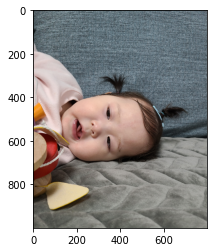

In [31]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_03.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_bgr = cv2.resize(img_bgr, (800, 1000))  # 800x1000의 크기로 Resize
img_show = img_bgr.copy()    # 출력용 이미지를 따로 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    # BGR → RGB 이미지로 바꾸기

# img_rgb90 =cv2.rotate(img_rgb, cv2.ROTATE_90_CLOCKWISE)
# cv2.imshow('original', img_rgb90)

plt.imshow(img_rgb)
plt.show()

In [32]:
detector_hog = dlib.get_frontal_face_detector()    # detector를 선언합니다
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)    # 얼굴의 bounding box 위치 찾기
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print(dlib_rects)   # 찾은 얼굴을 화면에 출력

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 10, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)


# 얼굴의 landmark의 위치 찾기

model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'    # landmark 모델을 불러오기
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)    # 얼굴 영역 박스 마다 face landmark를 찾아냅니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))    # face landmark 좌표를 저장해둡니다
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))

# 랜드마크를 영상에 출력해 보자

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_rgb, point, 10, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

rectangles[]


IndexError: list index out of range

* 옆으로 누워서 촬영한 사진에 대해서는 얼굴 영역 박스와 랜드마크 적용이 되지 않았다.
* 랜드마크 인식이 안되면 이미지에 스티커를 적용할 수 없다.

### 실행 속도가 중요할까요?

* 시중에 나와있는 카메라 어플을 생각한다면 빠른 인식과 실행 속도가 중요하다고 본다.

### 스티커앱을 만들 때 정확도가 얼마나 중요할까요?

* 다수에게 스티커를 적용하고 싶을 경우, 또는 사람의 얼굴이 아닌데 인식되는 경우가 있기 때문이다.
* 얼굴을 정확히 인식해서 스티커 적용을 하기 위해서는 정확도가 중요하다고 생각한다.

### 내가 발견한 문제점

### 여러명 인식하기 & 원하는 좌표만 선택해서 붙이기

다양한 각도의 사진으로 테스트를 하다보니 발견한 문제점에 관해서 기록해 본다.
내 사진으로 하기 부담스러워서 딸 아이의 사진으로 테스트를 하려고 했다.

아이의 얼굴에 랜드마크 좌표까지 찍었으나 스티커가 안붙어서 고민하고 있었는데
사용한 사진에서 딸이 입고 있던 옷에 프린팅 된 캐릭터들에게 스티커가 붙어 있는 걸 발견했다.(3명의 사람(?)을 인식했으나 정작 딸에겐 스티커가 안붙은 이런...)

인원수에 따른 문제점으로 분류해야 할지, 사람 인식에 대한 정확도의 문제로 분류를 해야될지.. 여러명 인식하는 부분에 있어서 얼굴 인식은 됬으나 모두에게 스티커 적용이 되지 않았다.

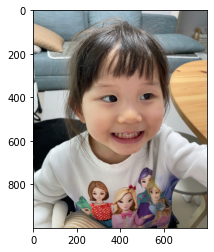

In [33]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_00.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_bgr = cv2.resize(img_bgr, (800, 1000))  # 800x1000의 크기로 Resize
img_show = img_bgr.copy()    # 출력용 이미지를 따로 보관

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    # BGR → RGB 이미지로 바꾸기
plt.imshow(img_rgb)

rectangles[[(247, 290) (632, 675)], [(529, 820) (591, 882)], [(262, 818) (337, 893)]]


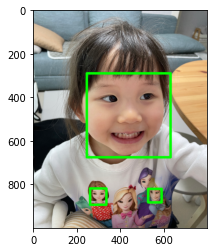

In [34]:
# 얼굴 검출

# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()

# 얼굴의 bounding box 위치 찾기

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)


# 찾은 얼굴을 화면에 출력

# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 10, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

얼굴 3 개, 랜드마크 68 개


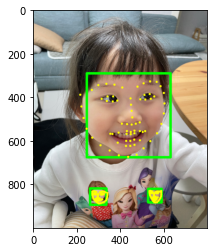

In [35]:
# 얼굴의 landmark의 위치 찾기

# landmark 모델을 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
# print(len(list_landmarks[0]))
print('얼굴', len(list_landmarks),'개,', '랜드마크', len(list_landmarks[0]), '개')

# 랜드마크를 영상에 출력해 보자

for landmark in list_landmarks:
    for i in range(len(list_landmarks)):
        for idx, point in enumerate(list_landmarks[i]): # list_lnadmarks의 모든 얼굴을 순회
            cv2.circle(img_show, point, 5, (0, 255, 255), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

plt.imshow(img_show_rgb)
plt.show()

(453, 525)
(558, 859)
(299, 863)


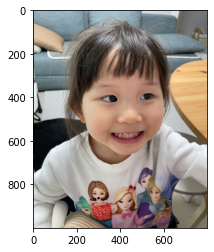

In [36]:
# 스티커 적용 위치 확인하기

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33])
    x = landmark[33][0]
    y = landmark[33][1]
    w = dlib_rect.width()
    h = dlib_rect.width()

sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
plt.imshow(img_sticker)

refined_x = int(x - w //2.1) # left
refined_y = int(y - h //2.2)  # top

# bounding box와 landmark가 없는 원본을 불러와서 바로 최종 결과만 출력
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

랜드마크는 3개의 얼굴에 찍히는데 스티커는 옷 프린팅에 빨간옷 입은 공주님한테만 붙음.
어디서 부터 꼬였는지 모르겠다. 여러명이 인식이 되서 스티커가 붙었다가 안붙었다가 난리다.
이 부분만큼은 해결하고 싶어서 붙잡고 있었지만.. 나의 한계인가보다..ㅠㅠ

## 회고

* 스티커 색상 반전(?): 스티커를 추가할 때, 스티커의 배경이 투명한 것이 아니라 흰색으로 나타나는 문제가 있었다. (스티커를 적용하니까 검은 부분은 투명하게, 배경 부분은 하얗게 출력됨.)
* 해당 문제는, np.where()에서 img_sticker의 값을 0이 아니라, 255로 설정하니 해결되었다.(np.where()는 img_sticker가 255이면 sticker_area의 값을 위치시키고, 아니라면 img_sticker의 값을 위치시키라는 의미이다.)


* 이미지 회전 : opencv 패키지의 rotate함수를 사용해서 이미지를 회전시킨 후 사용하려고 했다.
- 출처 : https://bskyvision.com/921

* 그런데 메모리 부족으로 쥬피터 노트북 커널연결이 끊겨서 포기하고 포토샵으로 이미지를 90도, 180도, 270도 회전시킨 후 불러왔다.
결과적으로, 회전된 사진에서 얼굴 영역 인식을 못했고 랜드마크가 찍히지 않아 스티커를 적용하지 못했다.


* 스티커 회전 : 랜드마크의 회전각을 구해 고양이 수염 스티커를 회전시켜서 적용했다.


* 스티커를 입체감 있게 혹은 원금감 있게 만들어서 붙이는 내용도 봤지만 아직 내 수준에서는 너무 높은 레벨의 내용이라 '이렇게도 가능하구나' 참고하고 넘어갔다. 추후에 이미지 처리 부분에 자신있어지면 도전해보려고 한다.